In [1]:
import rootutils
rootutils.setup_root(".")

from src.utils.conf_utils import get_cfg
import hydra
import hydra.utils
# import hydra.utils.instantiate
from lightning.pytorch.tuner import Tuner
import torch

In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
cfg = get_cfg([
    "experiment=classification_ft/imagenet1k/partmae/vit_b_16/4060ti",
    "model.net.pretrained_cfg_overlay.file=../../artifacts/model-2knf0d16:v0/backbone.ckpt",
    "trainer.min_epochs=0",
    "+data.output_tuple=True",
    "data.batch_size=64",
    "model.scheduler=null",
])

In [4]:
module = hydra.utils.instantiate(cfg.model)
trainer = hydra.utils.instantiate(cfg.trainer, default_root_dir=".")
datamodule = hydra.utils.instantiate(cfg.data)

Unexpected keys (norm.weight, norm.bias) found while loading pretrained weights. This may be expected if model is being adapted.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.


In [5]:
datamodule.setup()
trainloader = datamodule.train_dataloader()

INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Splitting validation set into validation and test sets.
INFO:HFDataModule:Finished splitting validation set into validation and test sets.
INFO:HFDataModule:Finished setting up datasets.


In [ ]:
import lightning as L
trainer = L.Trainer()

trainer.fit()

In [ ]:
# module.hparams.lr = 0.00001
import lightning as L

trainer = L.Trainer()
tuner = Tuner(trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(
    module,
    # train_dataloaders=trainloader,
    datamodule=datamodule,
    # min_lr=1e-8,
    # max_lr=1e-1,
    num_training=30,
    mode="exponential",
)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

In [ ]:
module.hparams.optimizer

functools.partial(<class 'torch.optim.adamw.AdamW'>, lr=5e-05, weight_decay=0.02, eps=1e-08)

In [ ]:
datamodule.setup()
trainloader = datamodule.train_dataloader()

INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Splitting validation set into validation and test sets.
INFO:HFDataModule:Finished splitting validation set into validation and test sets.
INFO:HFDataModule:Finished setting up datasets.


In [ ]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 224, 224])

  0%|          | 0/100 [00:00<?, ?it/s]

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E-01


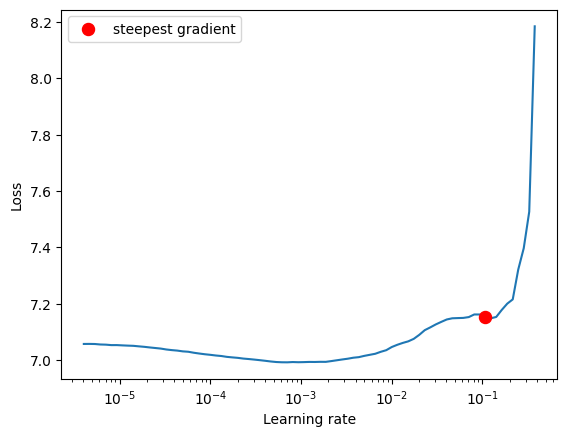

In [12]:
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
amp_config = {
    'device_type': 'cuda',
    'dtype': torch.bfloat16,
}
grad_scaler = torch.amp.GradScaler()

criterion = module.criterion
# optimizer = optim.AdamW(module.parameters(), lr=1e-7, weight_decay=0.02)
optimizer = module.hparams.optimizer(module.parameters())
lr_finder = LRFinder(module, optimizer, criterion, device="cuda", amp_backend="torch", amp_config=amp_config, grad_scaler=grad_scaler)
lr_finder.range_test(trainloader, start_lr=1e-6, end_lr=1, num_iter=100, accumulation_steps=16)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state